In [1]:
import numpy as np
import pandas as pd

import dynesty
import matplotlib.pyplot as plt
import kilonovanet
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import pickle
import corner
import signal

from matplotlib import cm
cmap = cm.get_cmap('magma')
colors = cmap(np.linspace(0,0.85,9))

import matplotlib
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('font', family='serif', size=14)
plt.rcParams["mathtext.fontset"] = "dejavuserif"
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300



In [2]:
df = pd.read_csv('./GW170817.dat', delimiter=' ')

df['date'] = pd.to_datetime(df['date'])
df['date_offset'] =  pd.to_datetime('2017-08-17T12:41:00.00')
df['delta_t'] = df['date'] - df['date_offset']
df = df[df['delta_t'] < np.timedelta64(14, 'D')]


lsst_bands = ['u', 'g', 'r', 'i', 'z', 'y']
other = ['J', 'H', 'K']
all_bands = ['u', 'g', 'r', 'i', 'z', 'y','J', 'H', 'K']
band_rules = ['LSST_']*6 + ['CTIO_']*3

band_rules_dict = {i:j for (i,j) in zip(all_bands, band_rules) }

times = np.array(df.delta_t.values / np.timedelta64(1, 'D'), dtype=float)
mags = np.array(df.mag.values, dtype=float)
err = np.array(df.mag_err.values, dtype=float)

bands = []
for band in df.band.values:
    bands.append(band_rules_dict[band] + band)
bands = np.array(bands)

truths = np.array([-2.27, -1.28, 49.5, 42.8])




Quantiles:
[(0.05, -2.7972407296892476), (0.5, -2.308732721301784), (0.95, -1.88680945907096)]
Quantiles:
[(0.05, -1.6774954393205055), (0.5, -1.1333497125618908), (0.95, -0.9588634095278259)]
Quantiles:
[(0.05, 28.47578003535196), (0.5, 47.64693682101695), (0.95, 81.20017031053358)]
Quantiles:
[(0.05, 24.794655239068764), (0.5, 64.45803170791245), (0.95, 87.56368909794242)]


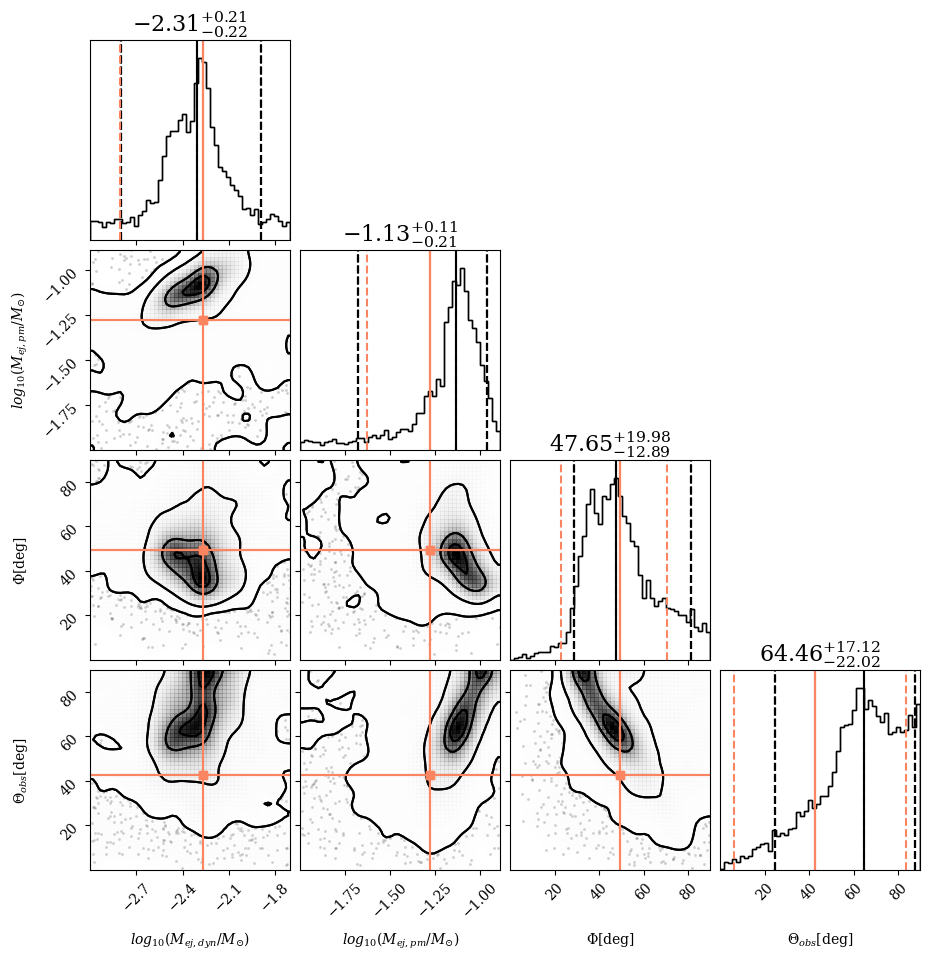

In [9]:
# with Dietrich's data limits
results = pickle.load(open('170817_results_dietrich_with1sigma.p', 'rb'))
samples = np.copy(results.samples)
samples[:,3] = np.rad2deg(np.arccos(samples[:,3]))
samples[:,0:2] = np.log10(samples[:,0:2])

figure = corner.corner(samples, show_titles=False, 
                       quantiles=[0.05,0.5, 0.95], 
                       truths=truths, 
                       levels=[0.1,0.32, 0.68, 0.95], 
                       labels=[r'$log_{10}(M_{ej, dyn}/M_{\odot})$', \
                               r'$log_{10}(M_{ej, pm}/M_{\odot})$', \
                               r'$\Phi$[deg]', \
                               r'$\Theta_{obs}$[deg]'], 
                       title_kwargs={"fontsize": 10},
                       bins=50,
                      truth_color=colors[7],
                      range=((-3, np.log10(0.02)), (-2, np.log10(0.13)), (0,90), (0,90)), smooth=2, verbose=True)



figure2 = corner.corner(samples, show_titles=True, fig=figure,
                       quantiles=[0.05, 0.95], 
                       truths=truths, 
                       levels=[0.1,0.32, 0.68, 0.95], 
                       title_kwargs={"fontsize": 16},
                       bins=50,
                      truth_color=colors[7],
                      range=((-3, np.log10(0.02)), (-2, np.log10(0.13)), (0,90), (0,90)), smooth=2)

axes = np.array(figure.axes).reshape((4, 4))
for i in range(4):
    ax = axes[i,i]
    ax.axvline(np.quantile(samples, 0.5, axis=0)[i],  linestyle='-', color='k')
    ax.axvline(np.quantile(samples, 0.05, axis=0)[i],  linestyle='--', color='k')
    ax.axvline(np.quantile(samples, 0.95, axis=0)[i],  linestyle='--', color='k')

    
means = np.array([-2.27, -1.28, 49.5, 42.8])
minus = np.array([0.54, 0.35, 26.65, 36.51])
plus = np.array([1.01, 0.42, 21.16, 40.62])

for i in range(4):
    ax = axes[i,i]
    ax.axvline(means[i],  linestyle='-', color=colors[7])
    ax.axvline(means[i]-minus[i],  linestyle='--', color=colors[7])
    ax.axvline(means[i]+plus[i],  linestyle='--', color=colors[7])
    

plt.savefig('gw170817_corner_dietrich.png', dpi=300)

In [6]:
lsst_bands = ['u', 'g', 'r', 'i', 'z', 'y']
other = ['J', 'H', 'K']
all_bands = ['u', 'g', 'r', 'i', 'z', 'y','J', 'H', 'K']
band_rules = ['LSST_']*6 + ['CTIO_']*3

band_rules_dict = {i:j for (i,j) in zip(all_bands, band_rules) }


times = np.tile(np.linspace(0,14,50), len(all_bands))
err = np.array(df.mag_err.values, dtype=float)

bands = []
for band in all_bands:
    bands.append(band_rules_dict[band] + band)
bands = np.repeat(bands, 50)

observations = kilonovanet.Observations(times, bands, mags, err,1.23E26)
model = kilonovanet.Model('/home/kamile/kilonovanet/data/metadata_bulla_bns.json',
                 '/home/kamile/kilonovanet/models/bulla-bns-latent-20-hidden-1000-CV-4-2021-04-21-epoch-200.pt',
                 filter_library_path='/home/kamile/kilonovanet/data/filter_data',
                 observations=observations)

mags_all_samples = np.empty((len(results.samples), 450))
for i,sample in enumerate(results.samples):
    mags_all_samples[i] = model.predict_magnitudes(sample)
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500


In [5]:
#pickle.dump(mags_all_samples, open('mags_all_samples_dietrich.p', 'wb'))
mags_all_samples = pickle.load(open('mags_all_samples_dietrich.p', 'rb'))

In [6]:
median_mags = np.quantile(mags_all_samples,0.5, axis=0)
q1_mags = np.quantile(mags_all_samples,0.05, axis=0)
q3_mags = np.quantile(mags_all_samples,0.95, axis=0)

In [7]:
from matplotlib import cm
cmap = cm.get_cmap('magma')
colors = cmap(np.linspace(0,0.85,9))
import matplotlib
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('font', family='serif', size=10)
plt.rcParams["mathtext.fontset"] = "dejavuserif"

times = np.tile(np.linspace(0,14,50), len(all_bands))


/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/kamile/miniconda3/envs/gwem/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


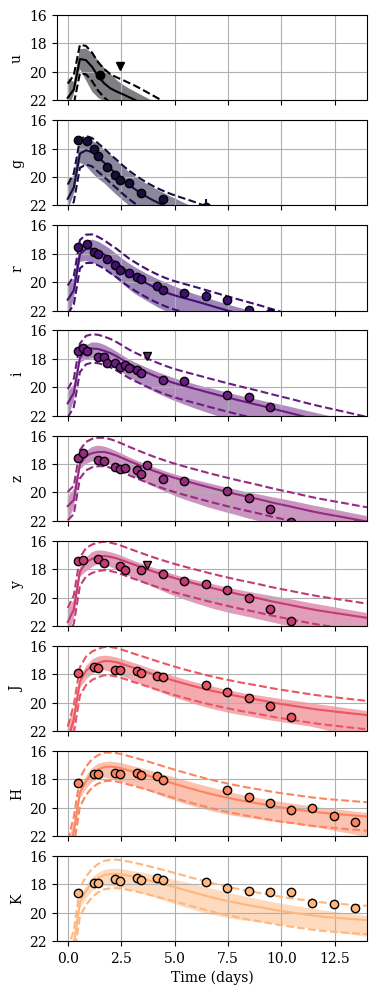

In [8]:
times = np.tile(np.linspace(0,14,50), len(all_bands))

fig, ax = plt.subplots(9, 1, sharex=True, figsize=(4,10))
for i,band in enumerate(all_bands):
    ax[i].grid()

    x = df[df['band'] == band].delta_t / np.timedelta64(1, 'D')
    y = df[df['band'] == band]['mag']
    y_err =  df[df['band'] == band]['mag_err']
    #print(pd.to_numeric(x).values)
    #ax[i].errorbar(x.values,y.values)
    for xx, yy, yy_err in zip(x.values, y.values, y_err.values): 
        if np.isfinite(yy_err):
            ax[i].errorbar(xx, yy, yerr=yy_err, marker='o',linestyle='None',mfc=colors[i], mec='k', ecolor=colors[i])
        else:
            ax[i].errorbar(xx, yy, yerr=yy_err, marker='v',linestyle='None',mfc=colors[i], mec='k', ecolor=colors[i])
    ax[i].fill_between(times[:50], q3_mags[i*50: (i+1)*50], q1_mags[i*50: (i+1)*50],color=colors[i], alpha=0.5, edgecolor='None')

    ax[i].plot(times[:50], median_mags[i*50: (i+1)*50], color=colors[i], alpha=1)
    ax[i].plot(times[:50], median_mags[i*50: (i+1)*50]+1, '--',color=colors[i], alpha=1)
    ax[i].plot(times[:50], median_mags[i*50: (i+1)*50]-1, '--',color=colors[i], alpha=1)

    ax[i].set_ylim(22,16)
    ax[i].set_ylabel(band)
    ax[i].set_xlim(-0.5, 14)
    if band == 'K':
        ax[i].set_xlabel('Time (days)')
plt.tight_layout()
plt.savefig('gw170817_lc_dietrich.png', dpi=300)